In [1]:
# !pip install torch==2.2.2 torchtext==0.17.2 nltk
# !pip install torchdata==0.7.1
# !pip install pyarrow

In [2]:
import torch
import os
import pickle
from model import ClassificationNet, train_epoch, evaluate_epoch, save_list_to_file, load_list_from_file
from torch.optim.lr_scheduler import CosineAnnealingLR

In [3]:
from dataloader import get_dataloaders, DEVICE

print("Imported successfully!")
print(f"Running on device: {DEVICE}")

BATCH_SIZE = 64
train_dataloader, valid_dataloader, test_dataloader, vocab = get_dataloaders(batch_size=BATCH_SIZE)

# --- Verification Step ---
print("\nVerifying by fetching one batch from train_dataloader...")
labels, texts = next(iter(train_dataloader))

print(f"Labels batch shape: {labels.shape}")
print(f"Texts batch shape: {texts.shape}")

Imported successfully!
Running on device: cuda
Loading data from Parquet files...
Vocabulary Size: 95811

Verifying by fetching one batch from train_dataloader...
Labels batch shape: torch.Size([64])
Texts batch shape: torch.Size([64, 72])


In [4]:
vocab_size = len(vocab)
num_classes = 4

In [5]:
EXPERIMENT_DIR = "runs/adam_from_epoch121"
METRICS_DIR = os.path.join(EXPERIMENT_DIR, "metrics") 
os.makedirs(EXPERIMENT_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True) 

print(f"Experiment artifacts will be saved in: {EXPERIMENT_DIR}")
print(f"Metrics will be saved in: {METRICS_DIR}")

Experiment artifacts will be saved in: runs/adam_from_epoch121
Metrics will be saved in: runs/adam_from_epoch121/metrics


In [6]:
model = ClassificationNet(vocab_size=vocab_size, num_class=num_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
criterion = torch.nn.CrossEntropyLoss()

In [7]:
# # define tits parameters after loading the checkpoint
# scheduler = None

In [8]:
start_epoch = 1
best_val_accuracy = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

In [11]:
BASE_CHECKPOINT_PATH = 'runs/adam_from_epoch101/checkpoint.pth'

In [13]:
if os.path.exists(BASE_CHECKPOINT_PATH):
    print(f"Found base checkpoint. Initializing model with weights from '{BASE_CHECKPOINT_PATH}'...")
    checkpoint = torch.load(BASE_CHECKPOINT_PATH)
    
    model.load_state_dict(torch.load('runs/adam_from_epoch101/best_model.pth'))
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.0002
        
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']                       # Continue history
    best_val_accuracy = checkpoint['best_val_accuracy']
    
else:
    print("No checkpoints found. Starting a completely new training run.")

Found base checkpoint. Initializing model with weights from 'runs/adam_from_epoch101/checkpoint.pth'...


In [14]:
start_epoch

121

In [15]:
EPOCHS = 140

In [16]:
optimizer.param_groups[0]['lr']

0.0002

In [18]:
print(f"Starting training from epoch {start_epoch}...")

for epoch in range(start_epoch, EPOCHS + 1):
    print("-" * 50)
    print(f"Epoch {epoch}/{EPOCHS}")
    
    # Run training and validation
    train_loss, train_acc = train_epoch(model, train_dataloader, criterion, optimizer, DEVICE)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    val_loss, val_acc = evaluate_epoch(model, valid_dataloader, criterion, DEVICE)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # summary
    print(f"\nEpoch Summary:")
    print(f"\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\tValid Loss: {val_loss:.4f} | Valid Acc: {val_acc*100:.2f}%")

    # Save best model to the experiment folder
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_model_path = os.path.join(EXPERIMENT_DIR, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to '{best_model_path}'")

print("-" * 50)
print("Training Finished!")
        
        
# Save final history to the experiment folder
for key, value in history.items():
    file_path = os.path.join(METRICS_DIR, f"{key}.pkl")
    save_list_to_file(value, file_path)

Training:   0%|          | 2/1725 [00:00<01:37, 17.66it/s, loss=0.1856]

Starting training from epoch 121...
--------------------------------------------------
Epoch 121/140


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 133.60it/s, loss=0.2634]



Epoch Summary:
	Train Loss: 0.2691 | Train Acc: 90.92%
	Valid Loss: 0.2634 | Valid Acc: 92.18%


Training:   0%|          | 3/1725 [00:00<01:10, 24.31it/s, loss=0.3481]

New best model saved to 'runs/adam_from_epoch121/best_model.pth'
--------------------------------------------------
Epoch 122/140


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 130.77it/s, loss=0.2591]



Epoch Summary:
	Train Loss: 0.2673 | Train Acc: 91.12%
	Valid Loss: 0.2591 | Valid Acc: 92.25%


Training:   0%|          | 5/1725 [00:00<00:42, 40.01it/s, loss=0.2450]

New best model saved to 'runs/adam_from_epoch121/best_model.pth'
--------------------------------------------------
Epoch 123/140


Training:   0%|          | 3/1725 [00:00<01:07, 25.52it/s, loss=0.2367]


Epoch Summary:
	Train Loss: 0.2662 | Train Acc: 91.07%
	Valid Loss: 0.2640 | Valid Acc: 91.99%
--------------------------------------------------
Epoch 124/140


Training:   0%|          | 4/1725 [00:00<00:43, 39.90it/s, loss=0.2525]


Epoch Summary:
	Train Loss: 0.2660 | Train Acc: 91.09%
	Valid Loss: 0.2649 | Valid Acc: 92.01%
--------------------------------------------------
Epoch 125/140


Training:   0%|          | 4/1725 [00:00<00:46, 37.18it/s, loss=0.2286]


Epoch Summary:
	Train Loss: 0.2635 | Train Acc: 91.24%
	Valid Loss: 0.2598 | Valid Acc: 92.03%
--------------------------------------------------
Epoch 126/140


Training:   0%|          | 3/1725 [00:00<01:07, 25.34it/s, loss=0.2621]


Epoch Summary:
	Train Loss: 0.2625 | Train Acc: 91.30%
	Valid Loss: 0.2571 | Valid Acc: 92.24%
--------------------------------------------------
Epoch 127/140


Training:   0%|          | 2/1725 [00:00<01:26, 19.93it/s, loss=0.2113]


Epoch Summary:
	Train Loss: 0.2588 | Train Acc: 91.37%
	Valid Loss: 0.2585 | Valid Acc: 92.00%
--------------------------------------------------
Epoch 128/140


Training:   0%|          | 3/1725 [00:00<01:00, 28.50it/s, loss=0.2587]


Epoch Summary:
	Train Loss: 0.2569 | Train Acc: 91.45%
	Valid Loss: 0.2660 | Valid Acc: 92.01%
--------------------------------------------------
Epoch 129/140


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 127.01it/s, loss=0.2540]



Epoch Summary:
	Train Loss: 0.2571 | Train Acc: 91.37%
	Valid Loss: 0.2540 | Valid Acc: 92.29%


Training:   0%|          | 4/1725 [00:00<00:49, 34.57it/s, loss=0.1819]

New best model saved to 'runs/adam_from_epoch121/best_model.pth'
--------------------------------------------------
Epoch 130/140


Training:   0%|          | 4/1725 [00:00<00:43, 39.75it/s, loss=0.2789]


Epoch Summary:
	Train Loss: 0.2560 | Train Acc: 91.44%
	Valid Loss: 0.2538 | Valid Acc: 92.06%
--------------------------------------------------
Epoch 131/140


Training:   0%|          | 4/1725 [00:00<00:51, 33.68it/s, loss=0.2673]


Epoch Summary:
	Train Loss: 0.2556 | Train Acc: 91.50%
	Valid Loss: 0.2586 | Valid Acc: 92.04%
--------------------------------------------------
Epoch 132/140


Training:   0%|          | 4/1725 [00:00<00:46, 36.68it/s, loss=0.2018]


Epoch Summary:
	Train Loss: 0.2539 | Train Acc: 91.51%
	Valid Loss: 0.2602 | Valid Acc: 92.20%
--------------------------------------------------
Epoch 133/140


Training:   0%|          | 4/1725 [00:00<00:49, 34.70it/s, loss=0.2622]


Epoch Summary:
	Train Loss: 0.2535 | Train Acc: 91.52%
	Valid Loss: 0.2614 | Valid Acc: 92.19%
--------------------------------------------------
Epoch 134/140


Training:   0%|          | 4/1725 [00:00<00:46, 37.33it/s, loss=0.2290]


Epoch Summary:
	Train Loss: 0.2521 | Train Acc: 91.60%
	Valid Loss: 0.2599 | Valid Acc: 92.24%
--------------------------------------------------
Epoch 135/140


Training:   0%|          | 5/1725 [00:00<00:38, 44.12it/s, loss=0.2555]


Epoch Summary:
	Train Loss: 0.2499 | Train Acc: 91.58%
	Valid Loss: 0.2608 | Valid Acc: 92.18%
--------------------------------------------------
Epoch 136/140


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 137.44it/s, loss=0.2529]



Epoch Summary:
	Train Loss: 0.2498 | Train Acc: 91.56%
	Valid Loss: 0.2529 | Valid Acc: 92.42%


Training:   0%|          | 5/1725 [00:00<00:41, 41.09it/s, loss=0.2397]

New best model saved to 'runs/adam_from_epoch121/best_model.pth'
--------------------------------------------------
Epoch 137/140


Training:   0%|          | 4/1725 [00:00<00:43, 39.71it/s, loss=0.1677]


Epoch Summary:
	Train Loss: 0.2489 | Train Acc: 91.65%
	Valid Loss: 0.2574 | Valid Acc: 92.26%
--------------------------------------------------
Epoch 138/140


Training:   0%|          | 3/1725 [00:00<01:05, 26.46it/s, loss=0.2453]


Epoch Summary:
	Train Loss: 0.2476 | Train Acc: 91.74%
	Valid Loss: 0.2596 | Valid Acc: 92.18%
--------------------------------------------------
Epoch 139/140


Training:   0%|          | 4/1725 [00:00<00:51, 33.67it/s, loss=0.2402]


Epoch Summary:
	Train Loss: 0.2453 | Train Acc: 91.79%
	Valid Loss: 0.2560 | Valid Acc: 92.32%
--------------------------------------------------
Epoch 140/140


Evaluating: 100%|██████████| 150/150 [00:01<00:00, 136.16it/s, loss=0.2579]



Epoch Summary:
	Train Loss: 0.2451 | Train Acc: 91.73%
	Valid Loss: 0.2579 | Valid Acc: 92.16%
--------------------------------------------------
Training Finished!


In [20]:
current_checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'best_val_accuracy': best_val_accuracy
}

torch.save(current_checkpoint, os.path.join(EXPERIMENT_DIR, 'checkpoint.pth'))

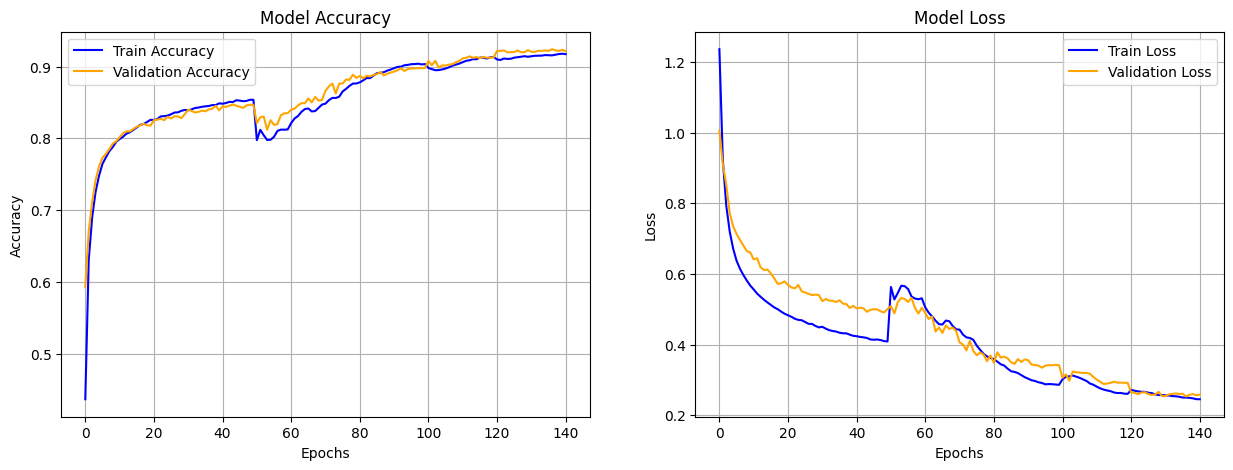

In [21]:
import matplotlib.pyplot as plt

train_losses = history['train_loss']
train_accuracies = history['train_acc']
val_losses = history['val_loss']
val_accuracies = history['val_acc']
    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting Accuracy
ax1.plot(train_accuracies, label='Train Accuracy', color='blue')
ax1.plot(val_accuracies, label='Validation Accuracy', color='orange')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plotting Loss
ax2.plot(train_losses, label='Train Loss', color='blue')
ax2.plot(val_losses, label='Validation Loss', color='orange')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.show()

In [22]:
best_model = ClassificationNet(vocab_size=vocab_size, num_class=num_classes).to(DEVICE)
best_model.load_state_dict(torch.load('runs/adam_from_epoch121/best_model.pth'))
print("Best model loaded and ready for testing.")

Best model loaded and ready for testing.


In [23]:
test_loss, test_acc = evaluate_epoch(best_model, test_dataloader, criterion, DEVICE)

Evaluating: 100%|██████████| 119/119 [00:00<00:00, 168.46it/s, loss=0.3439]


In [24]:
print("-" * 50)
print("Final Test Results:")
print(f"\tTest Loss: {test_loss:.4f}")
print(f"\tTest Accuracy: {test_acc*100:.2f}%")
print("-" * 50)

--------------------------------------------------
Final Test Results:
	Test Loss: 0.3439
	Test Accuracy: 90.14%
--------------------------------------------------
